In [1]:
import os
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

os.environ["CUDA_VISIBLE_DEVICES"] = "8"
device = "cuda:0" if torch.cuda.is_available() else "cpu"

sns.set_theme()
sns.set_context("paper")

In [2]:
class MLP(nn.Module):
    '''
    '''
    def __init__(self):
        '''
        '''
        super(MLP, self).__init__()
        
        self.fc1 = nn.Linear(9, 18)
        self.fc2 = nn.Linear(18, 36)
        self.fc3 = nn.Linear(36, 144)
        self.fc4 = nn.Linear(144, 20)
        
        self.activation = nn.Softmax(dim=0)
        self.dropout = nn.Dropout(p=0.5)
    
    def forward(self, x):
        '''
        '''
        
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.dropout(x)
        x = self.fc4(x)
        
        x = self.activation(x)
        return x

model = MLP()
model = model.to(device)
summary(model, input_size=(1, 9))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 18]             180
            Linear-2                [-1, 1, 36]             684
           Dropout-3                [-1, 1, 36]               0
            Linear-4               [-1, 1, 144]           5,328
           Dropout-5               [-1, 1, 144]               0
            Linear-6                [-1, 1, 20]           2,900
           Softmax-7                [-1, 1, 20]               0
Total params: 9,092
Trainable params: 9,092
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


In [3]:
class Pedreira_PCA(Dataset):
    def __init__(self, op="train"):
        '''
        '''
        self.op = op
        self.data_dir = "/export/gaon1/data/jteneggi/DL/pedreira"
        self.pca = PCA(n_components=9)
        self.gt_dir = os.path.join(self.data_dir, "ground_truth")
        self.spike_classes = np.load(os.path.join(self.gt_dir, "spike_classes.npy"), allow_pickle=True).squeeze()
        
    def __len__(self):
        if self.op=="train":
            return 80
        else:
            return 15
    
    def __getitem__(self, idx):
        if self.op == "val":
            idx += 80
        
        session_dir = os.path.join(self.data_dir, f"session_{idx}")
        channel_dir = os.path.join(session_dir, "channel_0")
        
        spikes = np.load(os.path.join(channel_dir, "spikes.npy"), allow_pickle=True).squeeze()
        reduced_data = self.pca.fit_transform(spikes)
        
        gt_classes = self.spike_classes[idx].squeeze()
        
        features = torch.from_numpy(reduced_data)
        targets = torch.from_numpy(gt_classes)
        
        return features, targets, spikes

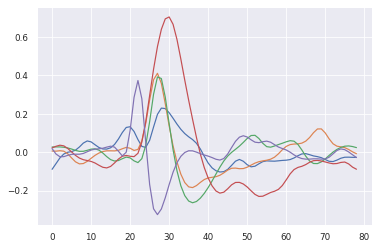

In [8]:
phases = ["train", "val"]

train_dataset = Pedreira_PCA()
val_dataset = Pedreira_PCA(op="val")

dataloaders = {
    "train": DataLoader(train_dataset, batch_size=1, shuffle=True),
    "val": DataLoader(val_dataset, batch_size=1, shuffle=False)
}

features, targets, spikes = next(iter(dataloaders["val"]))

for _features, _targets, _spikes in zip(features, targets, spikes):
    for spike, target in list(zip(_spikes, _targets))[:5]:
        plt.plot(spike)

In [5]:
data_dir = "/export/gaon1/data/jteneggi/DL"
pedreira_dir = os.path.join(data_dir, "pedreira")
gt_dir = os.path.join(pedreira_dir, "ground_truth")

spike_classes = np.load(os.path.join(gt_dir, "spike_classes.npy"), allow_pickle=True).squeeze()

n_sess = 95
for sess in range(n_sess):
    sess_dir = os.path.join(pedreira_dir, f"session_{sess}")
    channel_dir = os.path.join(sess_dir, "channel_0")
    spikes = np.load(os.path.join(channel_dir, "spikes.npy"), allow_pickle=True)
    spike_times = np.load(os.path.join(channel_dir, "spike_times.npy"), allow_pickle=True)
    gt_classes = spike_classes[sess].squeeze()
    assert len(spikes) == len(gt_classes)
    pca = PCA(n_components=9)